In [1]:
import os
import numpy as np
from skimage import io
from matplotlib import pyplot as plt
import cv2

In [2]:
def normalize_image(img, scale):
    """This is a simple opencv image normalization for 16 bit images.

    :param img: the numpy array of the 16bit image
    :return img: the normalized image
    """
    #cv2.normalize(img, img, 0, max, cv2.NORM_MINMAX)
    #norm = cv2.normalize(img, None, alpha=0, beta=1, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_32F)
    """
    lower_e = 0.05
    upper_e = 0.99
    lower = int(np.quantile(img[img>0], lower_e)) 
    upper = int(np.quantile(img[img>0], upper_e)) # gets almost the max value of img
    img[img > upper] = lower
    print(f'lower={lower} upper={upper}')
    """
    #norm = cv2.normalize(src=img, dst=None, alpha=0, beta=scale, norm_type=cv2.NORM_MINMAX, dtype=cv2.CV_16U)
    cv2.normalize(img, img, 0, scale, cv2.NORM_MINMAX)
    return img

def yoav(img, scale):
    """
    This scales the image to the limit specified. You can get this value
    by looking at the combined histogram of the image stack. It is quite
    often less than 30000 for channel 1.
    One of the reasons this takes so much RAM is a large float64 array is being
    multiplied by another large array. That is WHERE all the RAM is going!!!!!
    The scale is hardcoded to 45000 which was a good value from Yoav

    :param img: image we are working on.
    :param mask: binary mask file
    :param epsilon:
    :param limit: max value we wish to scale to
    :return: scaled image in 16bit format
    """
    epsilon=0.01
    #_max = np.quantile(img[mask > 0], 1 - epsilon) # gets almost the max value of img
    _max = np.quantile(img[img>0], 1 - epsilon) # gets almost the max value of img
    print('max is', _max)
    _range = scale
    data_type = np.uint16

    scaled = (img * (scale // _max)).astype(data_type) # scale the image from original values to e.g., 30000/10000
    del img
    scaled[scaled > _range] = _range # if values are > 16bit, set to 16bit
    #scaled = scaled * (mask > 0) # just work on the non masked values. This is where all the RAM goes!!!!!!!
    #del mask
    return scaled


def scaled(img, scale=20000):
    """First we find really high values, which are the bright spots and turn them down
    """
    dtype = img.dtype    
    epsilon = 0.99    
    _max = np.quantile(img[img>0], epsilon)
    scaled = (img * (scale / _max)).astype(dtype) # scale the image from original values to e.g., 30000/10000
    del img
    return scaled

def equalized(fixed, cliplimit=2):
    """Takes an image that has already been scaled and uses opencv adaptive histogram
    equalization. This cases uses 5 as the clip limit and splits the image into rows
    and columns. A higher cliplimit will make the image brighter. A cliplimit of 1 will
    do nothing. 

    :param fixed: image we are working on
    :return: a better looking image
    """
    
    clahe = cv2.createCLAHE(clipLimit=cliplimit, tileGridSize=(8, 8))
    fixed = clahe.apply(fixed)
    return fixed

def myhist(img, scale):
    hist, bins = np.histogram(img.flatten(), 65536, [0, 65536])  # Collect 16 bits histogram (65536 = 2^16).

    cdf = hist.cumsum()

    cdf_m = np.ma.masked_equal(cdf, 0)  # Find the minimum histogram value (excluding 0)
    cdf_m = (cdf_m - cdf_m.min())*scale/(cdf_m.max()-cdf_m.min())
    cdf = np.ma.filled(cdf_m,0).astype('uint16')

    # Now we have the look-up table...
    return cdf[img]

def myhistXXX(i):
    _max = 2**16 - 1
    hist, bins = np.histogram(i, _max, (0, _max))
    # discard colors at each end of the histogram which are used by only 0.05% 
    tmp = np.where(hist > hist.sum() * 0.0005)[0]
    i_min = tmp.min()
    i_max = tmp.max()
    # stretch hist
    tmp = (i.astype(np.int32) - i_min) / (i_max - i_min) * (_max-1)
    img = np.clip(tmp, 0, (_max-1))
    return img.astype(np.uint16)


In [3]:
animal = 'DK101'
DIR = f'/net/birdstore/Active_Atlas_Data/data_root/pipeline_data/{animal}/preps/tif'
filepath = os.path.join(DIR, 'DK101_slide033_2023_02_15_axion2_S1_C1.tif')

In [4]:
#For bigarr, look at 15812x43685, 16816x44463
startrow = 43685
endrow = 44463
startcol = 15812
endcol = 16816

In [5]:
bigarr = io.imread(filepath)
print(f'dtype={bigarr.dtype} shape={bigarr.shape}')

dtype=uint16 shape=(60788, 33268)


In [22]:
epsilon = 0.99
scale = 20000
_max = np.quantile(bigarr[bigarr>0], epsilon)
#scaled = (img * (scale / _max)).astype(dtype) # scale the image from original values to e.g., 30000/10000
print(f'_max={_max}')
scaling = scale/_max
print(f'scale/_max={scaling} scale={scale}')

_max=2591.0
scale/_max=7.719027402547279 scale=20000


In [18]:
%%time
#scale = 2**16 - 1
scale = 20000
bigarr_scaled = scaled(bigarr, scale)
print(f'dtype={bigarr_scaled.dtype} shape={bigarr_scaled.shape}')
cropped = bigarr_scaled[startrow:endrow, startcol:endcol]
print(f'dtype={cropped.dtype} shape={cropped.shape}')
outpath = os.path.join(DIR, 'cropped_test.tif')
io.imsave(outpath, cropped)

upper=2591 _max=2591.0
dtype=uint16 shape=(60788, 33268)
dtype=uint16 shape=(778, 1004)
CPU times: user 17 s, sys: 3.23 s, total: 20.2 s
Wall time: 20.2 s


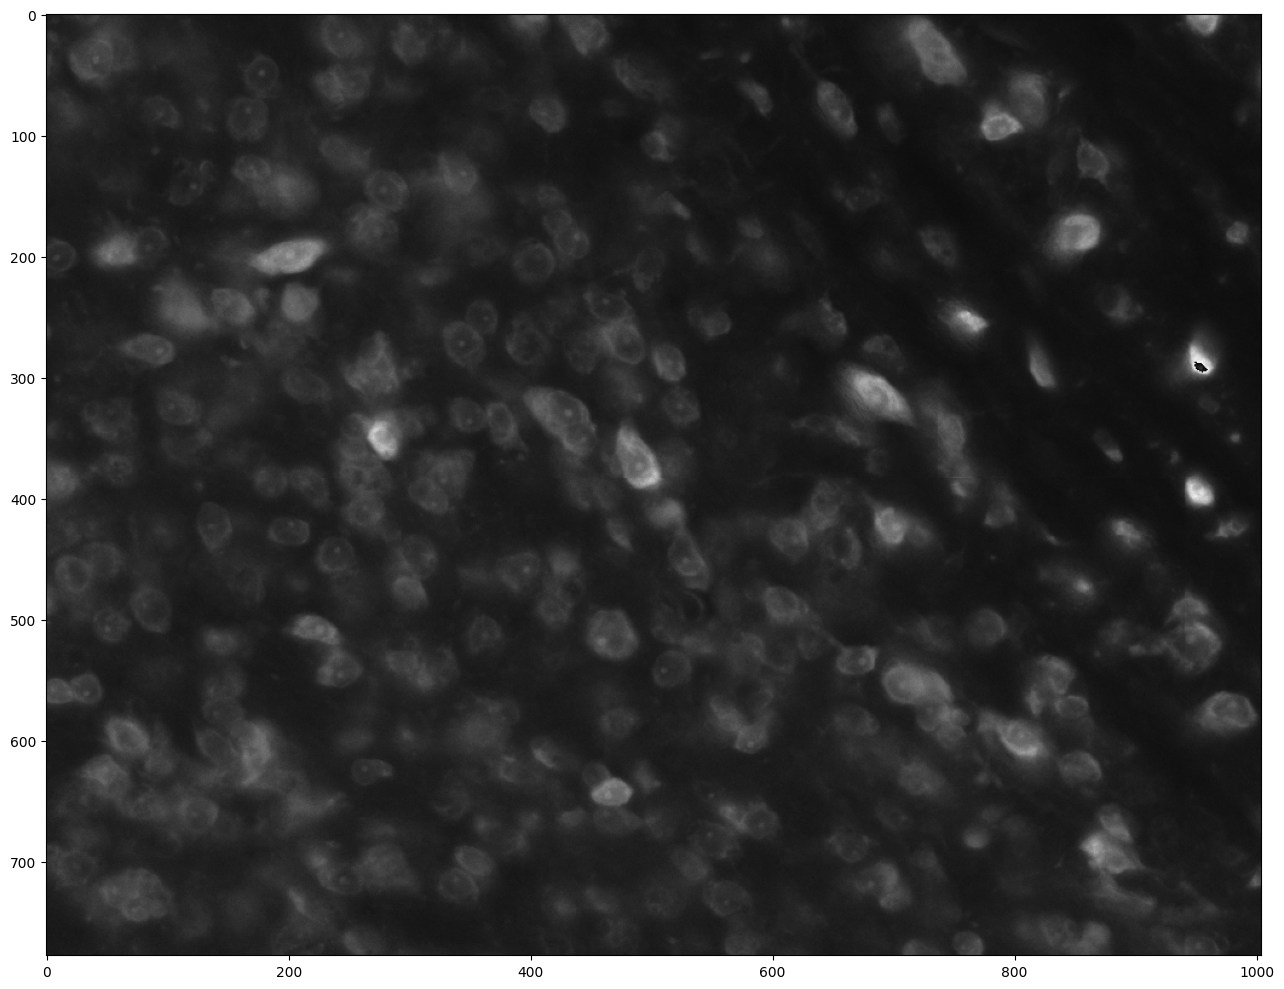

In [19]:
plt.rcParams["figure.figsize"] = [14, 10]
plt.rcParams["figure.autolayout"] = True
plt.imshow(cropped, cmap='gray')
#plt.show()

In [ ]:
scale = 2**16 - 1
cropped_scaled = scaled(cropped, scale)
outpath = os.path.join(DIR, f'cropped_scaled_{scale}.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_scaled)

In [ ]:
scale = 15000
cropped_normalize_image = normalize_image(cropped, scale)
outpath = os.path.join(DIR, f'cropped_normalize_image_{scale}.tif')
if not os.path.exists(outpath):
    print(f'dtype={cropped_normalize_image.dtype}')
    io.imsave(outpath, cropped_normalize_image)

In [ ]:
cliplimit=2
cropped_equalized_2 = equalized(cropped, cliplimit=cliplimit)
outpath = os.path.join(DIR, 'cropped_equalized_2.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_equalized_2)

In [ ]:
cropped_yoav = myhist(cropped, scale)
outpath = os.path.join(DIR, f'cropped_yoav_{scale}.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_yoav)

In [ ]:
scale = 2**16 - 1
cropped_myhist = myhist(cropped, scale)
outpath = os.path.join(DIR, f'cropped_myhist_{scale}.tif')
if not os.path.exists(outpath):
    io.imsave(outpath, cropped_myhist)

In [ ]:
plt.hist(cropped)
plt.show()